In [4]:
import matplotlib.pyplot as plt 
import numpy as np 
import tensorflow as tf 
import tensorflow_datasets as tfds 
from tensorflow.keras import layers 

In [5]:
(train_ds, val_ds, test_ds ), metadata = tfds.load(
    'tf_flowers', split=['train[:80]', 'train[80%:90%]', 'train[90%:]'], 
    with_info=True, 
    as_supervised=True
)


2023-09-04 15:55:10.300392: W tensorflow/tsl/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata.google.internal".


Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to /home/pa1/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [6]:
metadata

tfds.core.DatasetInfo(
    name='tf_flowers',
    full_name='tf_flowers/3.0.1',
    description="""
    A large set of images of flowers
    """,
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    data_path='/home/pa1/tensorflow_datasets/tf_flowers/3.0.1.incompleteRX2FP5',
    file_format=tfrecord,
    download_size=218.21 MiB,
    dataset_size=221.83 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=5),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=3670, num_shards=2>,
    },
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/example_images/flower_photos.tgz" }""",
)

In [7]:
metadata.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=5),
})

In [8]:
num_classes = metadata.features['label'].num_classes
print(num_classes)

5


2023-09-04 16:05:32.414605: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


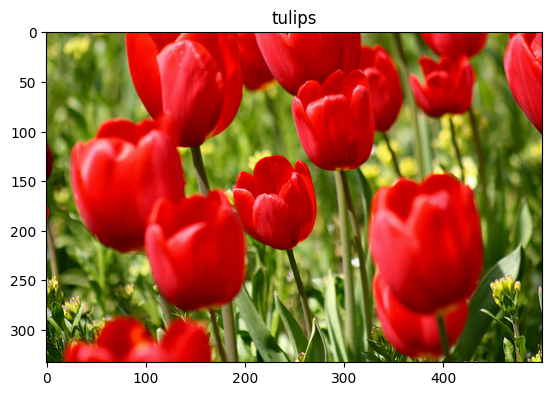

In [10]:
get_label_name = metadata.features['label'].int2str

image , label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

# Using Keras Preprocessing Layers 
We can use the Keras preprocessing layers to resize the image to a consistent shape, with tf.keras.layers.Resizing 

In [13]:
IMG_SIZE  = 180 

resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMG_SIZE, IMG_SIZE), 
    layers.Rescaling(1./255)
])
# The rescaling layer above standardizes pixel values to the [0,1] range . If instead we want it to be [-1,1], 
# we should write tf.keras.layers.Rescaling(1./127.5, offset=1)

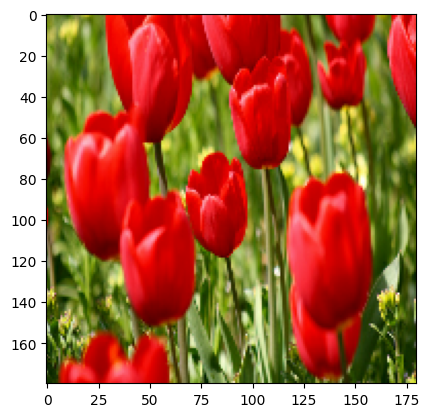

In [14]:
result = resize_and_rescale(image)
_ = plt.imshow(result)

In [16]:
# Verify that the pixels are in the [0,1] range 
print("Min and max pixel values:", result.numpy().min(), result.numpy().max())

Min and max pixel values: 0.0 1.0


# Data Augmentation 
We can use the Keras preprocessing layers for data augmentation as well 

In [19]:
# lets create a few preprocessing layers and apply them repeatedly to the same image 


In [20]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"), 
    layers.RandomRotation(0.2),
])

In [22]:
# Add the image to a batch 
image = tf.cast(tf.expand_dims(image, 0), tf.float32)

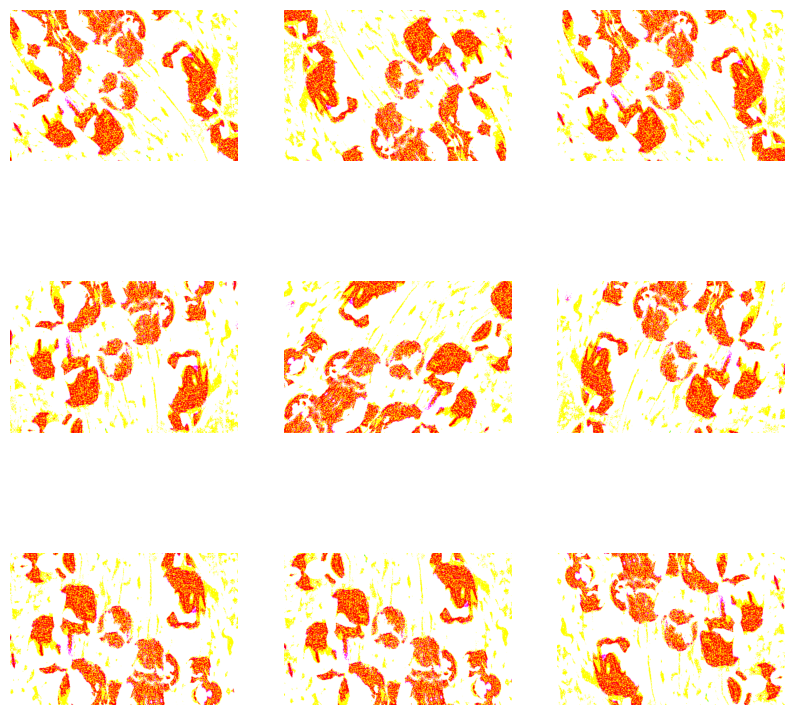

In [23]:
plt.figure(figsize=(10,10))
for i in range(9): 
    augmented_image = data_augmentation(image)
    ax = plt.subplot(3,3, i +1)
    plt.imshow(augmented_image[0])
    plt.axis("off")

In [24]:
# There are Two ways to use these preprocessing layers as part of the model 

In [25]:
#option 1 . Make the preprocessing layers part of your model 

In [26]:
model = tf.keras.Sequential([
    # Adding the preprocessing layers created earlier 
    resize_and_rescale, 
    data_augmentation, 
    layers.Conv2D(16,3, padding = 'same', activation = 'relu'), 
    layers.MaxPooling2D(), 
    # Rest of the Model 
])

In [27]:
# Two important thing here 
# Data Augmentation will run on device , synchronously with the rest of your layers , and benefit from GPU acclrn
# when the model is exported using model.save , the preprocessing layers will be saved along with the rest of
# model. If we later deploy this model, it will automatically standardize images(according to the configuration of 
# your layers). This saves from the effort of having to reimplement that logic server side 

In [28]:
# option 2 : Apply the Preprocessing layers to the dataset 

In [32]:
aug_ds = train_ds.map(
    lambda x,y: (resize_and_rescale(x,training= True), y))